In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np

In [2]:
L, d_model, d_h = 2, 16, 32

lstm = nn.LSTM(input_size=d_model, hidden_size=d_h, num_layers=L)

N_seq, B = 9, 3

X = torch.rand(N_seq, B, d_model)
h_0 = torch.zeros(L, B, d_h)
c_0 = torch.zeros(L, B, d_h)

out, (h_n, c_n) = lstm(X, (h_0, c_0))

print(out.shape)
print(h_n.shape)
print(c_n.shape)

torch.Size([9, 3, 32])
torch.Size([2, 3, 32])
torch.Size([2, 3, 32])


In [3]:
class Seq2SeqLSTM(nn.Module):

    def __init__(self, vocab_X, vocab_Y, d_input=16, d_target=16, d_h=16, num_layers=2):
        super().__init__()
        self.vocab_X = vocab_X
        self.vocab_Y = vocab_Y
        self.d_h = d_h
        self.num_layers = num_layers

        self.E_input = nn.Embedding(vocab_X.N_tokens, d_input)
        self.encoder_lstm = nn.LSTM(d_input, d_h, num_layers=num_layers)
        self.decoder_lstm = nn.LSTM(d_target, d_h, num_layers=num_layers)
        self.W_o = nn.Linear(d_h, d_target)
        self.E_target = nn.Embedding(vocab_Y.N_tokens, d_target)

    def init_hiddens(self, B):
        h_0 = torch.zeros(self.num_layers, B, self.d_h)
        c_0 = torch.zeros(self.num_layers, B, self.d_h)
        return h_0, c_0

    def forward(self, X, decoder_input, decoder_hidden_state=None):
        """
        X: [B, N_seq]
        target: [B, N_seq_t]

        returns logits for target tokens: [B, N_seq_t, V_target]
        """
        B, N_seq = X.shape
        if decoder_hidden_state is None:
            X_embed = self.E_input(X)
            X_embed = X_embed.transpose(0, 1)  # [N_seq, B, d_input]

            h_0, c_0 = self.init_hiddens(B)
            encoder_out, (enc_h_n, enc_c_n) = self.encoder_lstm(X_embed, (h_0, c_0))
            decoder_hidden_state = (enc_h_n, enc_c_n)

        target_embed = self.E_target(decoder_input)
        target_embed = target_embed.transpose(0, 1)
        decoder_out, decoder_hidden_state = self.decoder_lstm(target_embed, decoder_hidden_state)

        # decoder_out: [N_seq_t, B, d_h]
        decoder_out = decoder_out.transpose(0, 1)
        pred_target_vecs = self.W_o(decoder_out)
        logits = F.linear(pred_target_vecs, self.E_target.weight)

        return logits, decoder_hidden_state


def autoregressive_decode(X, model, bos, eos, max_len=20):
    B, N_seq = X.shape
    bos_tokens = torch.ones(B, 1, dtype=torch.long) * bos
    y_pred = [bos_tokens]
    logits = []
    decode_state = None
    for t in range(max_len):
        y_next_logit, decode_state = model(X, y_pred[-1], decode_state)
        _, y_next_token = torch.max(y_next_logit, axis=-1)
        logits.append(y_next_logit)
        y_pred.append(y_next_token)
        if y_next_token == eos:
            break

    return torch.cat(logits, dim=1), torch.cat(y_pred[1:], dim=1)

In [4]:
class Vocabulary(object):
    
    def __init__(self, d_embed=16):
        self.unk = 0
        self.pad = 1
        self.bos = 2
        self.eos = 3
        self.tokens = {
            '<unk>': self.unk,
            '<pad>': self.pad,
            '<s>': self.bos,
            '</s>': self.eos,
        }
        self.idxs = None
        self.building = True
        self.d_embed = d_embed
        
    def __len__(self):
        return len(self.tokens)
    
    def build(self):
        self.building = False
        self.idxs = {v: k for k, v in self.tokens.items()}
        self.N_tokens = len(self)
        
    def encode(self, tokens):
        ret = []
        for t in tokens:
            ret.append(self.encode_symbol(t))
        return ret
    
    def encode_symbol(self, token):
        ret = self.tokens.get(token, self.unk)
        if ret == self.unk and self.building:
            ret = len(self.tokens)
            self.tokens[token] = ret
        return ret
    
    def all_tokens(self):
        return list(self.tokens.keys())[3:]
    
    def decode(self, tokens):
        if type(tokens) == torch.Tensor:
            tokens = list(tokens.numpy().squeeze())
        if type(tokens) == np.ndarray:
            tokens = list(tokens.squeeze())
            
        if type(tokens) == list:
            return [self.idxs[t] for t in tokens]
        else:
            return self.idxs[tokens[0]]

In [7]:
def random_sentences(characters, N_samples=1000, sentence_len=5, N_words=100, word_len=4):
    
    vocab = Vocabulary()
    
    for i in range(N_words):
        w = ''.join(random.choices(characters, k=word_len))
        vocab.encode_symbol(w)
    
    vocab.build()
    words = vocab.all_tokens()
    samples = []
    samples_txt = []
    for i in range(N_samples):
        s = random.choices(words, k=sentence_len)
        samples_txt.append(' '.join(s))
        samples.append([vocab.bos] + vocab.encode(s) + [vocab.eos])
    
    return torch.tensor(samples), vocab, samples_txt

In [9]:
from tqdm import tqdm

X_all, vocab_X, X_txt = random_sentences('abcdefghijklmnop', N_samples=10, sentence_len=5, N_words=100, word_len=4)
Y_all, vocab_Y, Y_txt = random_sentences('ABCDEFGHIJKLMNOP', N_samples=10, sentence_len=5, N_words=100, word_len=4)


model = Seq2SeqLSTM(vocab_X, vocab_Y, d_h=16, num_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

losses = []
with tqdm(range(500)) as pbar:
    for i in pbar:
        batch_idxs = torch.randint(len(X_all), [32])
        X_batch = X_all[batch_idxs]
        Y_batch = Y_all[batch_idxs]

        optimizer.zero_grad()
        Y_logits, _ = model(X_batch, Y_batch)

        loss = loss_fn(Y_logits.flatten(end_dim=1)[:-1], Y_batch.flatten()[1:])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % 100 == 0:
            pbar.set_description(f'Loss={loss.item()}')

Loss=0.006429367698729038: 100%|██████████| 500/500 [00:03<00:00, 125.48it/s]


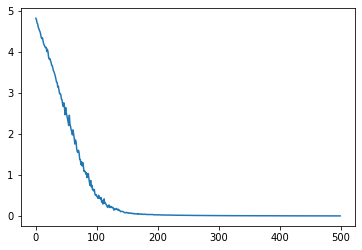

In [10]:
import matplotlib.pyplot as plt

plt.plot(losses);

In [12]:
logits, _ = model(X_all[[0]], Y_all[[0]])
_, y_pred = torch.max(logits, axis=-1)
print(y_pred[:, :-1])

logits, y_pred = autoregressive_decode(X_all[[0]], model, vocab_X.bos, vocab_X.eos)
print(y_pred)

tensor([[89, 30, 82, 25, 22,  3]])
tensor([[89, 30, 82, 25, 22,  3]])
